In [127]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import sys
from bs4 import BeautifulSoup
import re
import unicodedata
import folium
from folium.plugins import MarkerCluster
from folium.plugins import MousePosition
from folium.features import DivIcon
import wget

import plotly.express as px
import plotly.graph_objects as go
import dash 
from dash import dcc 
from dash import html
from dash.dependencies import Input, Output

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


import csv, sqlite3
import prettytable
prettytable.DEFAULT = 'DEFAULT'

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

In [4]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [6]:
spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)
# print(response.content)
response.status_code

200

In [8]:
static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'
response = requests.get(static_json_url)
# print(response.content)
df = pd.json_normalize(response.json())

In [9]:
df.head(1)

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN


In [10]:
df= df[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]
df = df[df['cores'].map(len)==1]
df = df[df['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
df['cores'] = df['cores'].map(lambda x : x[0])
df['payloads'] = df['payloads'].map(lambda x : x[0])

df['date'] = pd.to_datetime(df['date_utc']).dt.date
df= df[df['date'] <= datetime.date(2020, 11, 13)]

- From the rocket -> booster name
- From the payload -> the mass of the payload , the orbit that it is going to
- From the launchpad -> the name of the launch site being used, the longitude, and the latitude.
- From cores -> the outcome of the landing, the type of the landing, number of flights with that core, whether gridfins were used, whether the core is reused, whether legs were used, the landing pad used, the block of the core which is a number used to seperate version of cores, the number of times this specific core has been reused, and the serial of the core.

In [15]:
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [17]:
getBoosterVersion(df)

In [18]:
BoosterVersion[0:5]

['Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 1', 'Falcon 9']

In [19]:
getLaunchSite(df)
Longitude[0:5]

[167.7431292, 167.7431292, 167.7431292, 167.7431292, -80.577366]

In [20]:
getPayloadData(df)
getCoreData(df)

In [21]:
launch_dict = {'FlightNumber': list(df['flight_number']),
'Date': list(df['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [27]:
df = pd.DataFrame(launch_dict)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FlightNumber    94 non-null     int64  
 1   Date            94 non-null     object 
 2   BoosterVersion  94 non-null     object 
 3   PayloadMass     88 non-null     float64
 4   Orbit           94 non-null     object 
 5   LaunchSite      94 non-null     object 
 6   Outcome         94 non-null     object 
 7   Flights         94 non-null     int64  
 8   GridFins        94 non-null     bool   
 9   Reused          94 non-null     bool   
 10  Legs            94 non-null     bool   
 11  LandingPad      64 non-null     object 
 12  Block           90 non-null     float64
 13  ReusedCount     94 non-null     int64  
 14  Serial          94 non-null     object 
 15  Longitude       94 non-null     float64
 16  Latitude        94 non-null     float64
dtypes: bool(3), float64(4), int64(3), obj

In [31]:
df = df[df["BoosterVersion"]== "Falcon 9"]

In [33]:
df.loc[:,'FlightNumber'] = list(range(1, df.shape[0]+1))
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857


In [35]:
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [37]:
mean_plm = df["PayloadMass"].mean(axis=0)
df["PayloadMass"] = df["PayloadMass"].fillna(mean_plm)
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [39]:
max_blk = df["Block"].value_counts().idxmax()
df["Block"] = df["Block"].fillna(max_blk)
df.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        0
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

In [41]:
df.shape

(90, 17)

In [43]:
df["LaunchSite"].value_counts()

LaunchSite
CCSFS SLC 40    55
KSC LC 39A      22
VAFB SLC 4E     13
Name: count, dtype: int64

In [45]:
df["Orbit"].value_counts()

Orbit
GTO      27
ISS      21
VLEO     14
PO        9
LEO       7
SSO       5
MEO       3
ES-L1     1
HEO       1
SO        1
GEO       1
Name: count, dtype: int64

In [47]:
landing_outcomes = df["Outcome"].value_counts()
landing_outcomes

Outcome
True ASDS      41
None None      19
True RTLS      14
False ASDS      6
True Ocean      5
False Ocean     2
None ASDS       2
False RTLS      1
Name: count, dtype: int64

In [49]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 True ASDS
1 None None
2 True RTLS
3 False ASDS
4 True Ocean
5 False Ocean
6 None ASDS
7 False RTLS


In [51]:
bad_outcomes=set(landing_outcomes.keys()[[1,3,5,6,7]])
bad_outcomes

{'False ASDS', 'False Ocean', 'False RTLS', 'None ASDS', 'None None'}

In [53]:
landing_class = []
for i in df["Outcome"]:
    if i in bad_outcomes:
        landing_class.append(0)
    else:
        landing_class.append(1)

df['Class'] = landing_class
df.sample()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
85,82,2020-06-30,Falcon 9,3880.0,MEO,CCSFS SLC 40,True ASDS,1,True,False,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,1


In [55]:
df["Class"].mean()

0.6666666666666666

In [57]:
df_sql = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df_sql.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

101

In [58]:
%reload_ext sql

In [61]:
%sql sqlite:///my_data1.db

In [63]:
%sql DROP TABLE IF EXISTS SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


[]

In [65]:
%sql create table SPACEXTABLE as select * from SPACEXTBL where Date is not null;

 * sqlite:///my_data1.db
Done.


[]

In [67]:
%sql SELECT DISTINCT Launch_Site FROM SPACEXTABLE;

 * sqlite:///my_data1.db
Done.


Launch_Site
CCAFS LC-40
VAFB SLC-4E
KSC LC-39A
CCAFS SLC-40


In [69]:
%%sql
SELECT * 
FROM SPACEXTABLE
WHERE Launch_Site LIKE 'CCA%'
LIMIT 5;

 * sqlite:///my_data1.db
Done.


Date,Time (UTC),Booster_Version,Launch_Site,Payload,PAYLOAD_MASS__KG_,Orbit,Customer,Mission_Outcome,Landing_Outcome
2010-06-04,18:45:00,F9 v1.0 B0003,CCAFS LC-40,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success,Failure (parachute)
2010-12-08,15:43:00,F9 v1.0 B0004,CCAFS LC-40,"Dragon demo flight C1, two CubeSats, barrel of Brouere cheese",0,LEO (ISS),NASA (COTS) NRO,Success,Failure (parachute)
2012-05-22,7:44:00,F9 v1.0 B0005,CCAFS LC-40,Dragon demo flight C2,525,LEO (ISS),NASA (COTS),Success,No attempt
2012-10-08,0:35:00,F9 v1.0 B0006,CCAFS LC-40,SpaceX CRS-1,500,LEO (ISS),NASA (CRS),Success,No attempt
2013-03-01,15:10:00,F9 v1.0 B0007,CCAFS LC-40,SpaceX CRS-2,677,LEO (ISS),NASA (CRS),Success,No attempt


In [71]:
%%sql
SELECT SUM("PAYLOAD_MASS__KG_") AS Total_Payload_Mass
FROM SPACEXTABLE
WHERE Customer LIKE '%NASA (CRS)%';

 * sqlite:///my_data1.db
Done.


Total_Payload_Mass
48213


In [73]:
%%sql
SELECT AVG("PAYLOAD_MASS__KG_") AS Average_Payload_Mass
FROM SPACEXTABLE
WHERE Booster_version is 'F9 v1.1';

 * sqlite:///my_data1.db
Done.


Average_Payload_Mass
2928.4


In [75]:
%%sql
SELECT MIN(Date) AS First_Successful_Landing_Date
FROM SPACEXTABLE
WHERE Landing_Outcome = 'Success (ground pad)';

 * sqlite:///my_data1.db
Done.


First_Successful_Landing_Date
2015-12-22


In [77]:
%%sql
SELECT Booster_Version, Landing_Outcome, PAYLOAD_MASS__KG_
FROM SPACEXTABLE
WHERE Landing_Outcome == 'Success (drone ship)' 
AND 4000 < PAYLOAD_MASS__KG_ 
AND PAYLOAD_MASS__KG_< 6000;

 * sqlite:///my_data1.db
Done.


Booster_Version,Landing_Outcome,PAYLOAD_MASS__KG_
F9 FT B1022,Success (drone ship),4696
F9 FT B1026,Success (drone ship),4600
F9 FT B1021.2,Success (drone ship),5300
F9 FT B1031.2,Success (drone ship),5200


In [79]:
%%sql
SELECT Mission_Outcome, COUNT(*) AS Total
FROM SPACEXTABLE
GROUP BY Mission_Outcome;

 * sqlite:///my_data1.db
Done.


Mission_Outcome,Total
Failure (in flight),1
Success,98
Success,1
Success (payload status unclear),1


In [81]:
%%sql
SELECT Booster_Version
FROM SPACEXTABLE
WHERE PAYLOAD_MASS__KG_	= (SELECT MAX(PAYLOAD_MASS__KG_) 
FROM SPACEXTABLE);


 * sqlite:///my_data1.db
Done.


Booster_Version
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2
F9 B5 B1058.3
F9 B5 B1051.6


In [83]:
%%sql
SELECT SUBSTR(DATE, 6,2) AS Months
, Landing_Outcome, Booster_Version, Launch_Site
FROM SPACEXTABLE
WHERE (Landing_Outcome == "Failure (drone ship)") AND (SUBSTR(Date,0,5)='2015');

 * sqlite:///my_data1.db
Done.


Months,Landing_Outcome,Booster_Version,Launch_Site
01,Failure (drone ship),F9 v1.1 B1012,CCAFS LC-40
04,Failure (drone ship),F9 v1.1 B1015,CCAFS LC-40


In [85]:
%%sql
SELECT Landing_Outcome, COUNT(*) AS Count_Landing_Outcome
FROM SPACEXTABLE
WHERE Date BETWEEN '2010-06-04' AND '2017-03-20'
GROUP BY Landing_Outcome
ORDER BY Count_Landing_Outcome DESC;

 * sqlite:///my_data1.db
Done.


Landing_Outcome,Count_Landing_Outcome
No attempt,10
Success (drone ship),5
Failure (drone ship),5
Success (ground pad),3
Controlled (ocean),3
Uncontrolled (ocean),2
Failure (parachute),2
Precluded (drone ship),1


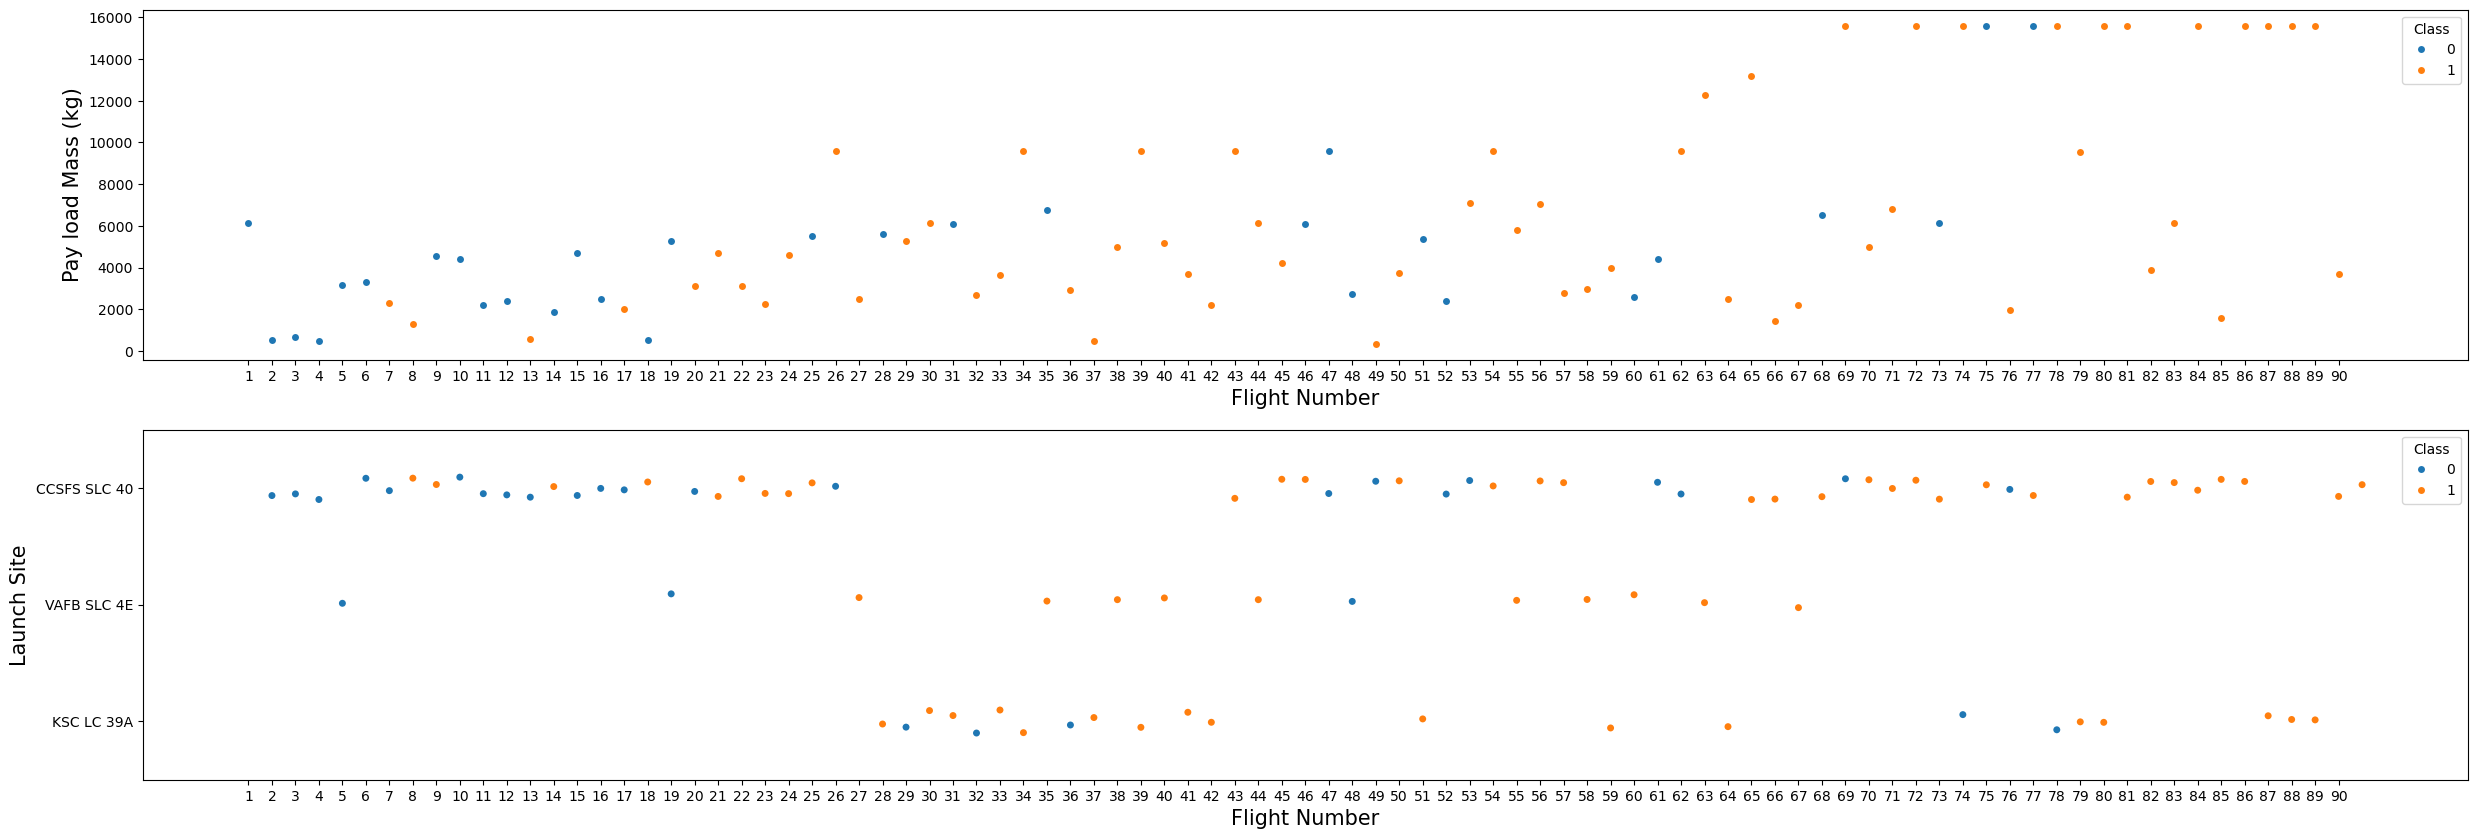

In [87]:
plt.figure(figsize=(30,10))
ax1 = plt.subplot(2,1,1)
sns.stripplot(y="PayloadMass", x="FlightNumber", hue="Class", data=df, ax=ax1)
ax1.set_xlabel("Flight Number",fontsize=15)
ax1.set_ylabel("Pay load Mass (kg)",fontsize=15)

ax2 = plt.subplot(2,1,2, sharex=ax1)
sns.stripplot(y="LaunchSite", x="FlightNumber", hue="Class", data=df, ax=ax2)
ax2.set_xlabel("Flight Number",fontsize=15)
ax2.set_ylabel("Launch Site",fontsize=15)
plt.show()

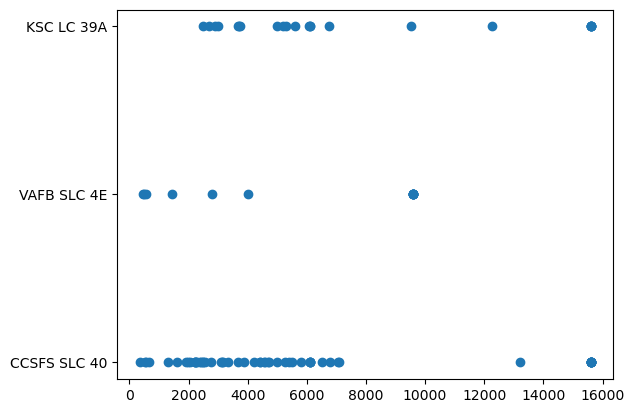

In [88]:
plt.scatter(x="PayloadMass", y="LaunchSite", data=df)

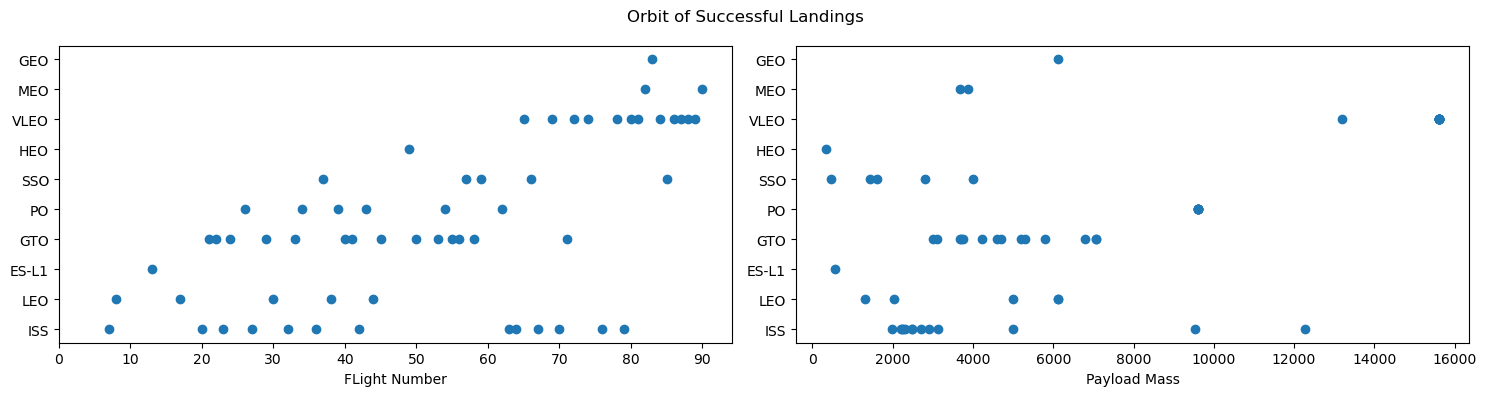

In [89]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1,2,1)
ax1.scatter(x="FlightNumber", y="Orbit", data=df[df["Class"]==1])
ax1.set_xlabel('FLight Number')
ax1.set_xticks(range(0,91,10))

ax2 = plt.subplot(1,2,2)
ax2.scatter(x="PayloadMass", y="Orbit", data=df[df["Class"]==1])
ax2.set_xlabel("Payload Mass")

plt.suptitle("Orbit of Successful Landings")
plt.tight_layout()
plt.show()

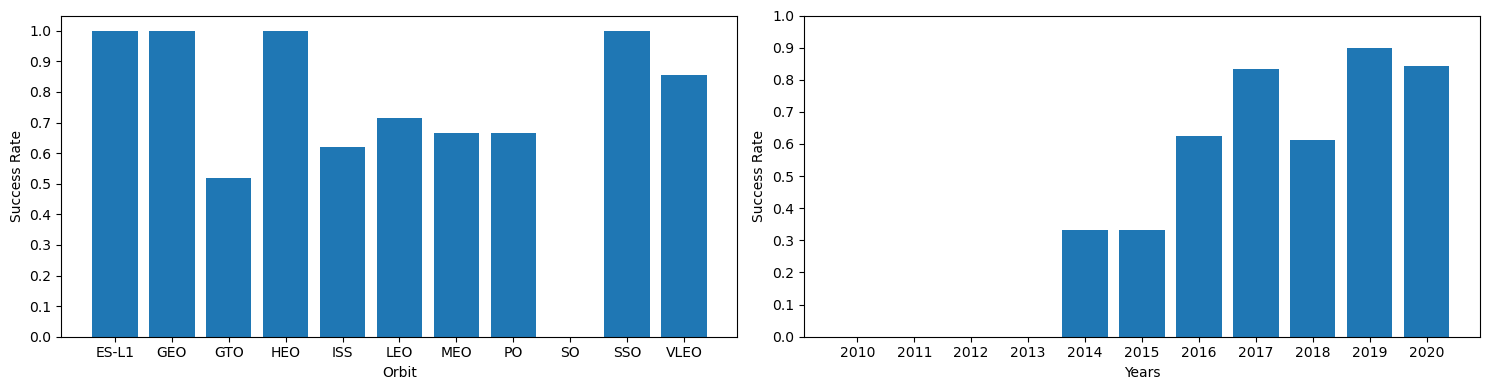

In [93]:
plt.figure(figsize=(15,4))
ax1=plt.subplot(1,2,1)
g1 = df.groupby("Orbit")["Class"].mean().reset_index()
ax1.bar(x="Orbit", height="Class", data=g1)
ax1.set_xlabel("Orbit")
ax1.set_ylabel("Success Rate")
ax1.set_yticks(np.arange(0,1.1,0.1))


ax2= plt.subplot(1,2,2)
g2 = pd.DataFrame()
g2['year'],g2["Class"] = pd.to_datetime(df["Date"]).dt.year, df["Class"]
g2 = g2.groupby("year")["Class"].mean().reset_index()
plt.bar(x="year", height="Class", data=g2)
ax2.set_xlabel("Years")
ax2.set_xticks(range(2010,2021))
ax2.set_ylabel("Success Rate")
ax2.set_yticks(np.arange(0,1.1,0.1))
plt.tight_layout()
plt.show()

In [95]:
features = df[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features.head()

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004


<Axes: >

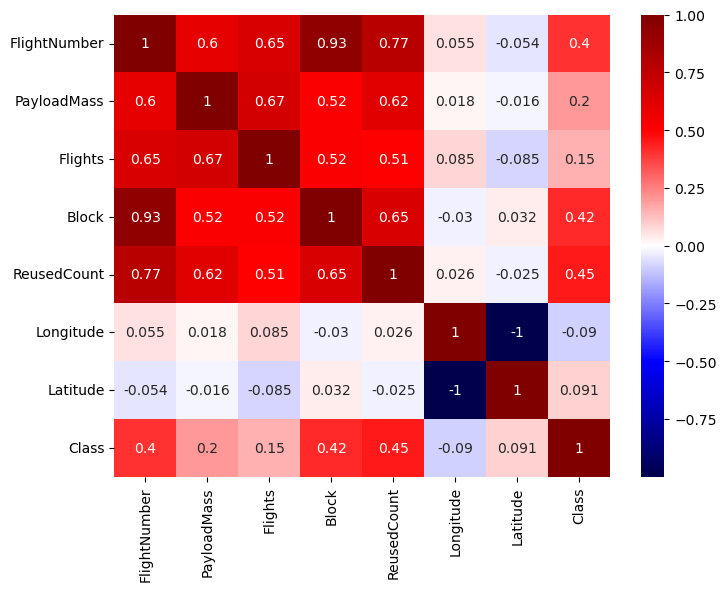

In [97]:
heat = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(8,6))
sns.heatmap(heat, cmap="seismic", annot=True)

In [99]:
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(df[['Orbit', 'LaunchSite', 'LandingPad', 'Serial', 'GridFins', 'Reused', 'Legs']]).toarray()
encoded_data = pd.DataFrame(encoded_data, columns = encoder.get_feature_names_out())
df_3 = pd.concat([encoded_data, df.reset_index().drop(['Orbit', 'LaunchSite', 'LandingPad', 'Serial'], axis=1)], axis=1)
df_3.drop(['LandingPad_None', 'index', 'Date', 'BoosterVersion', 'Outcome', 'Longitude', 'Latitude', 'Class', 'GridFins', 'Reused', 'Legs'], inplace=True, axis=1)

In [101]:
df_3.shape

(90, 83)

In [103]:
spacex_df = df[['LaunchSite', 'Latitude', 'Longitude', 'Class', 'PayloadMass']]
launch_sites_df = spacex_df.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df

,LaunchSite,Latitude,Longitude,Class,PayloadMass
0,CCSFS SLC 40,28.561857,-80.577366,0,6123.547647
1,KSC LC 39A,28.608058,-80.603956,1,2490.000000
2,VAFB SLC 4E,34.632093,-120.610829,0,500.000000


In [220]:
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
marker = folium.map.Marker(nasa_coordinate, 
                           icon=DivIcon(icon_size=(20,20), icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC'))
site_map.add_child(circle)
site_map.add_child(marker)

In [222]:
circle = folium.map.FeatureGroup()

for lat, lng, label in zip(launch_sites_df["Latitude"], launch_sites_df["Longitude"], launch_sites_df["LaunchSite"]):
    circle.add_child(
        folium.vector_layers.CircleMarker(
            [lat, lng],
            popup=label,
            color='orange',
            fill=False,
            # fill_color='yellow',
            # fill_opacity=0.8,
            radius=5  # Set a smaller pixel radius here
        )
    )

site_map.add_child(circle)

In [145]:
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df.loc[:, 'Marker_Color'] = spacex_df.loc[:,'Class'].apply(assign_marker_color)

In [143]:
spacex_df.sample(3)

,LaunchSite,Latitude,Longitude,Class,PayloadMass,Marker_Color
29,VAFB SLC 4E,34.632093,-120.610829,1,9600.0,green
34,KSC LC 39A,28.608058,-80.603956,0,6070.0,red
74,CCSFS SLC 40,28.561857,-80.577366,1,6800.0,green


In [224]:
marker_cluster = MarkerCluster()
site_map.add_child(marker_cluster)

for index, row in spacex_df.iterrows():
    lat = row['Latitude']
    lng = row['Longitude']
    launch_site = row['LaunchSite']
    marker_color = row['Marker_Color']
    
    folium.Marker(
        location=[lat, lng],
        popup=launch_site,
        icon=folium.Icon(color=marker_color)
    ).add_to(marker_cluster)

# Display the map
site_map


In [228]:
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

In [116]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

distance_coastline = calculate_distance(28.561857, -80.577366, 28.56197, -80.56803)

In [226]:
distance_marker = folium.Marker([28.56197, -80.56803], icon=DivIcon( icon_size=(20,20), icon_anchor=(0,0), html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % "{:10.2f} KM".format(distance_coastline)))
lines=folium.PolyLine(locations=[(28.561857, -80.577366), (28.56197, -80.56803)], weight=1)
site_map.add_child(lines)
site_map.add_child(distance_marker)

In [147]:
spacex_df[spacex_df['LaunchSite']=='CCSFS SLC 40']

,LaunchSite,Latitude,Longitude,Class,PayloadMass,Marker_Color
4,CCSFS SLC 40,28.561857,-80.577366,0,6123.547647,red
5,CCSFS SLC 40,28.561857,-80.577366,0,525.000000,red
6,CCSFS SLC 40,28.561857,-80.577366,0,677.000000,red
8,CCSFS SLC 40,28.561857,-80.577366,0,3170.000000,red
9,CCSFS SLC 40,28.561857,-80.577366,0,3325.000000,red
10,CCSFS SLC 40,28.561857,-80.577366,1,2296.000000,green
11,CCSFS SLC 40,28.561857,-80.577366,1,1316.000000,green
12,CCSFS SLC 40,28.561857,-80.577366,0,4535.000000,red
13,CCSFS SLC 40,28.561857,-80.577366,0,4428.000000,red
14,CCSFS SLC 40,28.561857,-80.577366,0,2216.000000,red


In [122]:
df.describe()

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Longitude,Latitude,Class
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,45.500000,6123.547647,1.788889,3.500000,3.188889,-86.366477,29.449963,0.666667
std,26.124701,4732.115291,1.213172,1.595288,4.194417,14.149518,2.141306,0.474045
min,1.000000,350.000000,1.000000,1.000000,0.000000,-120.610829,28.561857,0.000000
25%,23.250000,2510.750000,1.000000,2.000000,0.000000,-80.603956,28.561857,0.000000
50%,45.500000,4701.500000,1.000000,4.000000,1.000000,-80.577366,28.561857,1.000000
75%,67.750000,8912.750000,2.000000,5.000000,4.000000,-80.577366,28.608058,1.000000
max,90.000000,15600.000000,6.000000,5.000000,13.000000,-80.577366,34.632093,1.000000


In [230]:
app = dash.Dash(__name__)

app.layout = html.Div(children=[html.H1('SpaceX Launch Records Dashboards', style={'textAlign': 'center', 'color': '#503D36', 'font-size': 30}),
                                html.Div(dcc.Dropdown(id='site-dropdown', options=[{'label': 'All Sites', 'value': 'ALL'}, {'label': 'CCSFS SLC 40', 'value': 'CCSFS SLC 40'}, {'label': 'KSC LC 39A', 'value': 'KSC LC 39A'}, {'label': 'VAFB SLC 4E', 'value': 'VAFB SLC 4E'}],
                                                      value='ALL', placeholder="Select a launch site", searchable=True)),
                                html.Div(dcc.Graph(id='success-pie-chart')),
                                html.Div(dcc.RangeSlider(id='payload-slider', min=0, max=10000, step=1000, marks={i: f'{i}' for i in range(0, 11000, 1000)}, value=[350, 15600])),
                                html.Div(dcc.Graph(id='success-payload-scatter-chart'))])


@app.callback([Output(component_id='success-pie-chart', component_property='figure'), 
               Output(component_id='success-payload-scatter-chart', component_property='figure')],
              [Input(component_id='site-dropdown', component_property='value'), 
               Input(component_id="payload-slider", component_property="value")])
def update_charts(entered_site, payload_range):
    filtered_df = spacex_df[(spacex_df['PayloadMass'] >= payload_range[0]) & 
                            (spacex_df['PayloadMass'] <= payload_range[1])]
    
    if entered_site == 'ALL':
        pie_fig = px.pie(filtered_df, values='Class', names='LaunchSite', title='Total Success Launches by Site')
    else:
        pie_fig = px.pie(filtered_df[filtered_df['LaunchSite']==entered_site], names='Class', title=f'Total Success Launches for Site {entered_site}')
    scatter_fig = px.scatter(filtered_df[filtered_df['LaunchSite']==entered_site] if entered_site != 'ALL' else filtered_df,
                             x="PayloadMass", y="Class", title="Payload vs. Success", hover_data=["LaunchSite"], color="Class", color_continuous_scale=px.colors.sequential.Viridis)
    scatter_fig.update_layout(plot_bgcolor='rgba(0, 73, 0, 0.25)')
    return pie_fig, scatter_fig

if __name__ == '__main__': 
    app.run(debug=True)

In [105]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell 
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name    

In [107]:
url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
response=requests.get(url).text
soup = BeautifulSoup(response)
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [109]:
html_tables = soup.find_all("table")
len(html_tables)

25

In [111]:
first_launch_table = html_tables[2]
print(first_launch_table)

<table class="wikitable plainrowheaders collapsible" style="width: 100%;">
<tbody><tr>
<th scope="col">Flight No.
</th>
<th scope="col">Date and<br/>time (<a href="/wiki/Coordinated_Universal_Time" title="Coordinated Universal Time">UTC</a>)
</th>
<th scope="col"><a href="/wiki/List_of_Falcon_9_first-stage_boosters" title="List of Falcon 9 first-stage boosters">Version,<br/>Booster</a> <sup class="reference" id="cite_ref-booster_11-0"><a href="#cite_note-booster-11"><span class="cite-bracket">[</span>b<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Launch site
</th>
<th scope="col">Payload<sup class="reference" id="cite_ref-Dragon_12-0"><a href="#cite_note-Dragon-12"><span class="cite-bracket">[</span>c<span class="cite-bracket">]</span></a></sup>
</th>
<th scope="col">Payload mass
</th>
<th scope="col">Orbit
</th>
<th scope="col">Customer
</th>
<th scope="col">Launch<br/>outcome
</th>
<th scope="col"><a href="/wiki/Falcon_9_first-stage_landing_tests" title="Falcon 

In [113]:
column_names = []
for i in list(first_launch_table.find("tbody").find_all("th")):
    if (i!=None) and (len(i)>0) and (i["scope"]=="col"):
        column_names.append(i.text.strip())

column_names

['Flight No.',
 'Date andtime (UTC)',
 'Version,Booster [b]',
 'Launch site',
 'Payload[c]',
 'Payload mass',
 'Orbit',
 'Customer',
 'Launchoutcome',
 'Boosterlanding']

In [114]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
# del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight No.'] = []
launch_dict['Launch site'] = []
launch_dict['Payload'] = []
launch_dict['Payload mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch outcome'] = []
# Added some new columns
launch_dict['Version Booster']=[]
launch_dict['Booster landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [117]:
extracted_row = 0
for table_number,table in enumerate(soup.find_all('table',"wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th: ## Look back to the table you find out why
            if rows.th.string:
                flight_number=rows.th.string.strip()
                flag=flight_number.isdigit()
        else:
            flag=False
            
        #get table element 
        row=rows.find_all('td')
        #if it is number save cells in a dictonary 
        if flag:
            extracted_row += 1
            launch_dict['Flight No.'].append(flight_number)
            
            datatimelist=date_time(row[0])
            date = datatimelist[0].strip(',')
            launch_dict['Date'].append(date)
            time = datatimelist[1]
            launch_dict['Time'].append(time)
              
            bv=booster_version(row[1])
            if not(bv):
                bv=row[1].a.string
                launch_dict['Version Booster'].append(bv)
            
            launch_site = row[2].a.string
            launch_dict['Launch site'].append(launch_site)
            
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)
            
            payload_mass = get_mass(row[4])
            launch_dict['Payload mass'].append(payload_mass)
            
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)
            
            # Customer
            # TODO: Append the customer into launch_dict with key `Customer`
            if row[6].a:
                customer = row[6].a.string
            else:
                customer = None 
            launch_dict['Customer'].append(customer)

            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch outcome'].append(launch_outcome)
            
            booster_landing = landing_status(row[8])
            launch_dict['Booster landing'].append(booster_landing)

In [118]:
df2= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })
df2

,Flight No.,Date andtime (UTC),"Version,Booster [b]",Launch site,Payload[c],Payload mass,Orbit,Customer,Launchoutcome,Boosterlanding,Payload,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,NaN,NaN,CCAFS,NaN,0,LEO,SpaceX,NaN,NaN,Dragon Spacecraft Qualification Unit,Success\n,F9 v1.1,Failure,4 June 2010,18:45
1,2,NaN,NaN,CCAFS,NaN,0,LEO,NASA,NaN,NaN,Dragon,Success,F9 v1.1,Failure,8 December 2010,15:43
2,3,NaN,NaN,CCAFS,NaN,525 kg,LEO,NASA,NaN,NaN,Dragon,Success,F9 v1.1,No attempt\n,22 May 2012,07:44
3,4,NaN,NaN,CCAFS,NaN,"4,700 kg",LEO,NASA,NaN,NaN,SpaceX CRS-1,Success\n,F9 v1.1,No attempt,8 October 2012,00:35
4,5,NaN,NaN,CCAFS,NaN,"4,877 kg",LEO,NASA,NaN,NaN,SpaceX CRS-2,Success\n,F9 v1.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,117,NaN,NaN,CCSFS,NaN,"15,600 kg",LEO,SpaceX,NaN,NaN,Starlink,Success\n,NaN,Success,9 May 2021,06:42
117,118,NaN,NaN,KSC,NaN,"~14,000 kg",LEO,SpaceX,NaN,NaN,Starlink,Success\n,NaN,Success,15 May 2021,22:56
118,119,NaN,NaN,CCSFS,NaN,"15,600 kg",LEO,SpaceX,NaN,NaN,Starlink,Success\n,NaN,Success,26 May 2021,18:59
119,120,NaN,NaN,KSC,NaN,"3,328 kg",LEO,NASA,NaN,NaN,SpaceX CRS-22,Success\n,NaN,Success,3 June 2021,17:29


In [119]:
df2.to_csv('spacex_web_scraped.csv', index=False)

In [120]:
df2["Launch site"].value_counts()

Launch site
CCAFS             40
KSC               33
Cape Canaveral    20
VAFB              16
CCSFS             12
Name: count, dtype: int64

In [ ]:
df , df_3

In [129]:
y=df["Class"].to_numpy()
scale = StandardScaler()
X = scale.fit_transform(df_3)

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
y_test.shape

(18,)

In [140]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()
cv=10
logreg_cv = GridSearchCV(lr, parameters, cv=cv)
logreg_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [142]:
print(f"Best Params: {logreg_cv.best_params_}\nBest Score: {logreg_cv.best_score_}\nTestset Score: {logreg_cv.score(X_test, y_test)}")

Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.8464285714285713
Testset Score: 0.8333333333333334


In [148]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

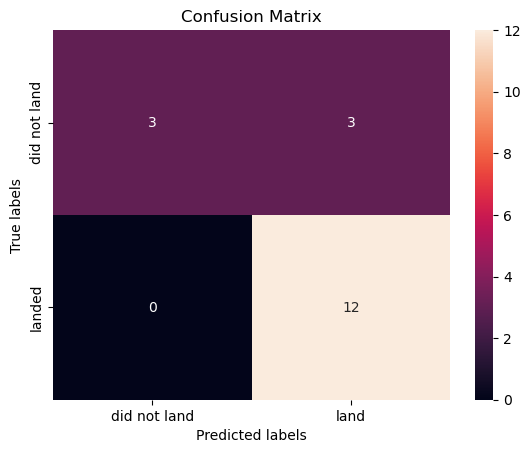

In [180]:
yhat=logreg_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

In [154]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()
cv=10
svm_cv = GridSearchCV(svm, parameters, cv=cv)
svm_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [156]:
print(f"Best Params: {svm_cv.best_params_}\nBest Score: {svm_cv.best_score_}\nTest-set Score: {svm_cv.score(X_test, y_test)}")

Best Params: {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
Best Score: 0.8357142857142856
Test-set Score: 0.8333333333333334


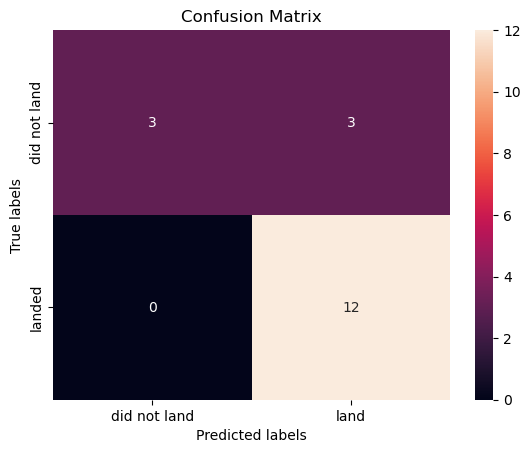

In [182]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

In [164]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': [None, 'sqrt', 'log2'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [166]:
print(f"Best Params: {tree_cv.best_params_}\nBest Score: {tree_cv.best_score_}\nTest-set Score: {tree_cv.score(X_test, y_test)}")

Best Params: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
Best Score: 0.8892857142857145
Test-set Score: 0.8333333333333334


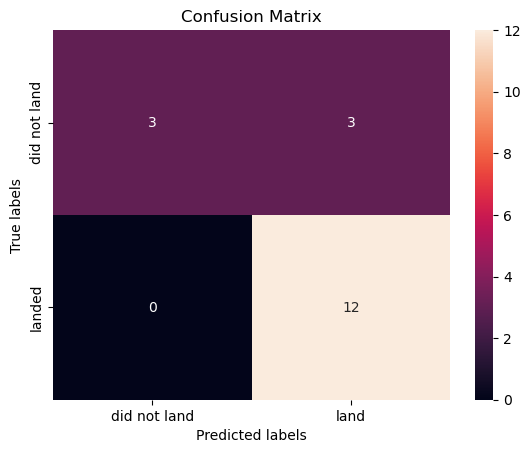

In [169]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

In [174]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
knn_cv = GridSearchCV(KNN, parameters, cv=10)
knn_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

In [176]:
print(f"Best Params: {knn_cv.best_params_}\nBest Score: {knn_cv.best_score_}\nTest-set Score: {knn_cv.score(X_test, y_test)}")

Best Params: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Best Score: 0.8482142857142858
Test-set Score: 0.8333333333333334


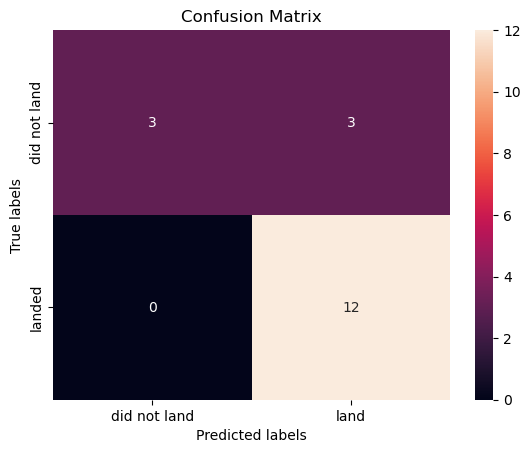

In [178]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(y_test,yhat)

In [198]:
print(f"LogisticRegression:\nBest Params: {logreg_cv.best_params_}\nBest Score: {logreg_cv.best_score_}\nTestset Score: {logreg_cv.score(X_test, y_test)}\nSVM:\nBest Params: {svm_cv.best_params_}\nBest Score: {svm_cv.best_score_}\nTest-set Score: {svm_cv.score(X_test, y_test)}\nDecisionTree:\nBest Params: {tree_cv.best_params_}\nBest Score: {tree_cv.best_score_}\nTest-set Score: {tree_cv.score(X_test, y_test)}\nKNN:\nBest Params: {knn_cv.best_params_}\nBest Score: {knn_cv.best_score_}\nTest-set Score: {knn_cv.score(X_test, y_test)}")

LogisticRegression:
Best Params: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.8464285714285713
Testset Score: 0.8333333333333334
SVM:
Best Params: {'C': 0.03162277660168379, 'gamma': 0.001, 'kernel': 'linear'}
Best Score: 0.8357142857142856
Test-set Score: 0.8333333333333334
DecisionTree:
Best Params: {'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'random'}
Best Score: 0.8892857142857145
Test-set Score: 0.8333333333333334
KNN:
Best Params: {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Best Score: 0.8482142857142858
Test-set Score: 0.8333333333333334


I would lean toward choosing the Decision Tree model. The Decision Tree achieved a higher best cross-validation score (≈0.8893) compared to the other models. For an application such as predicting Falcon 9 landings—a task with high stakes—being able to understand and explain the decision-making process is invaluable. A Decision Tree provides a clear, visual set of decision rules, making it easier to interpret which features are critical (for example, key sensor readings or trajectory parameters) in predicting a successful landing.